In [1]:
%matplotlib widget
from notebook_res import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# settings plot
grid_dim  = 1       # frame size
grid_res  = 21      # number of per axis
dim       = 2       # dimension
line_res  = 1000    # points per line
init_k    = -1      # initial curvature
k_range   = [-1,1]  # curvature range
k_res     = 0.1     # curvature resolution

In [3]:
# define euclidean grid
grid  = []
dots  = np.linspace(-grid_dim,grid_dim,line_res)
for i in np.linspace(-grid_dim,grid_dim,grid_res):
  line = np.stack((dots, np.full(dots.shape, i)), axis=1)
  grid.append(line)
  grid.append(line[:,::-1])

grid = np.stack(grid,axis=0)

# define non euclidean grids for different curvatures
ks    = np.linspace(k_range[0], k_range[1], int((k_range[1]-k_range[0])/k_res)+1)
O     = np.array([0,0])#np.zeros(shape=grid.shape[2])
geometries  = []

for k in ks:
  mapped = np.array([exponential_map(line, O, k) for line in grid])
  geometries.append(mapped)
geometries = np.stack(geometries[::-1],axis=0)

# define triangle
num_lines   = 3
side_length = 1 / np.e
angles      = np.deg2rad([0, 120, 240])
radius      = side_length / (np.sqrt(3))
vertices    = np.stack([radius * np.array([np.cos(a), np.sin(a)]) for a in angles])

triangle    = []
for i in range(num_lines):
  start   = vertices[i]
  end     = vertices[(i + 1) % num_lines]
  line    = np.linspace(start, end, line_res)
  triangle.append(line)
triangle  = np.stack(triangle)

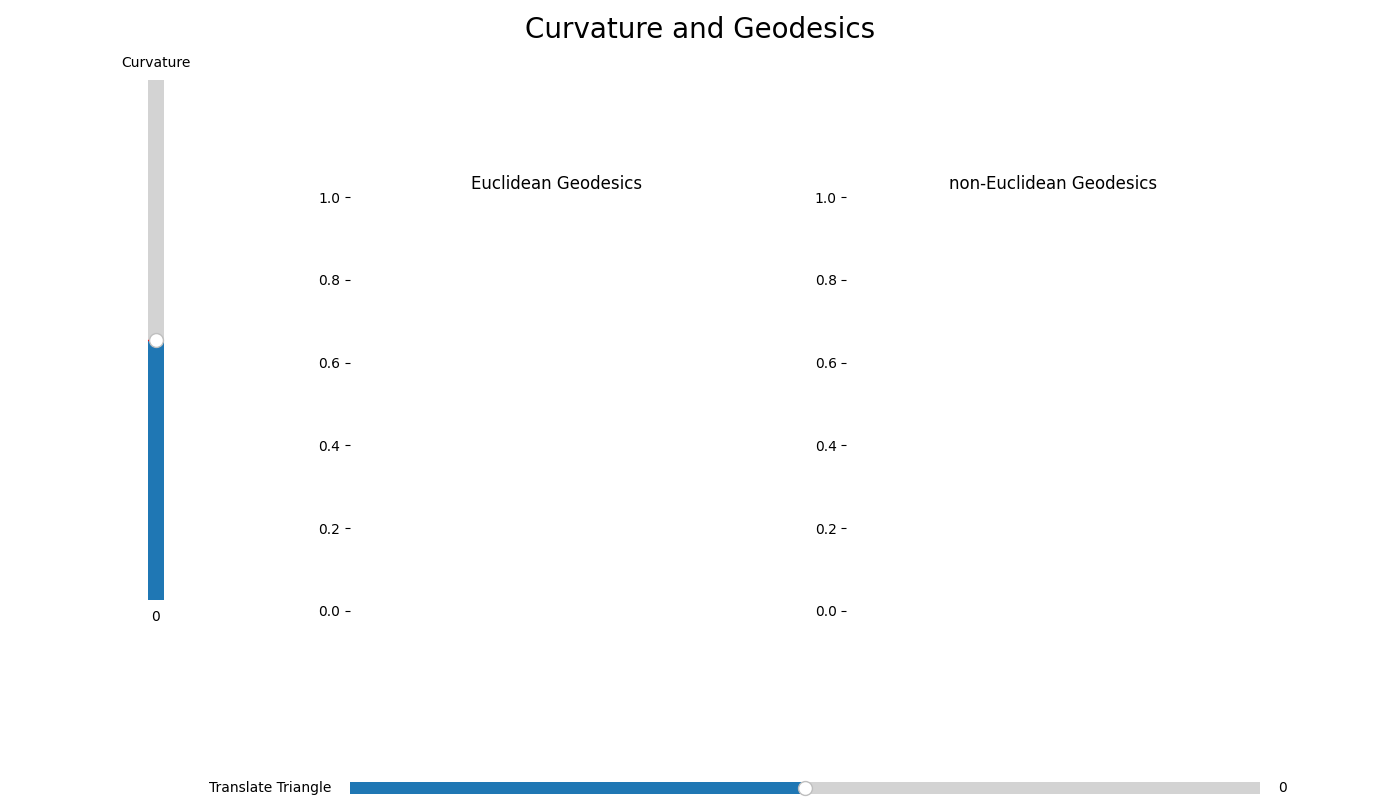

In [4]:
# initialize pyplot figure with sliders
dimmed_color  = 'lightgrey'
bold_color    = 'black'
thin_width    = 1
thick_width   = 2
fig,ax        = plt.subplots(
  1, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [1],'hspace': 0.5,}
)
fig.subplots_adjust(left=0.25)
fig.suptitle('Curvature and Geodesics', fontsize=20)
ax[0].set_title('Euclidean Geodesics')
ax[1].set_title('non-Euclidean Geodesics')

for _ in ax.flatten():
  _.spines['top'].set_visible(False)                                           
  _.spines['right'].set_visible(False)
  _.spines['left'].set_visible(False)
  _.spines['bottom'].set_visible(False)
  _.set_xticks([])  # remove x-axis ticks
  _.set_aspect('equal', adjustable='box')  # equal aspect ratio

# define sliders
ax_k = fig.add_axes([0.1, 0.25, 0.0225, 0.65])
ax_t = fig.add_axes([0.25, 0, 0.65, 0.03])
k_slider = Slider(
  ax          = ax_k,
  label       = 'Curvature',
  valmax      = k_range[1],
  valmin      = k_range[0],
  valinit     = 0,
  valstep     = 0.1,
  orientation = 'vertical'
)
t_slider = Slider(
  ax      = ax_t,
  label   = 'Translate Triangle',
  valmax  = 1,
  valmin  = -1,
  valinit = 0,
  valstep = 0.1,
)

# <center> Geometry </center>

In [ ]:

# updates
def get_curved_space(k:float)->None:
  R = min(1/np.sqrt(np.abs(k)),1)
  for _ in ax.flatten():
    _.clear()
    _.set_xticks([])

  # translation vector
  translation_vec = R*t_slider.val*np.array([1, 0])

  # select geometry corresponding to selected curvature
  idx       = np.where(ks==k)[0][0]
  geometry  = geometries[idx,:,:,:]

  # plot grid
  criteria  = norm(grid,axis=2) < R
  ax[0].scatter(grid[criteria][:,0], grid[criteria][:,1], c=dimmed_color, s=0.5,
              marker ='o')

  # plot non euclidean grid
  criteria  = norm(geometry,axis=2) < R
  ax[1].scatter(geometry[criteria][:,0], geometry[criteria][:,1], c=dimmed_color, s=0.5,
              marker ='o')

  # plot triangles 
  for translated_line in (triangle + translation_vec):
    criteria  = norm(translated_line, axis=1) < R
    curved_line     = exponential_map(translated_line, O, k)
    ax[0].plot(translated_line[criteria][:,0], translated_line[criteria][:,1], 
               c=bold_color, linewidth=thick_width)
    ax[1].plot(curved_line[criteria][:,0], curved_line[criteria][:,1], c=bold_color, 
               linewidth=thick_width)

  # define geodesics
  phi = np.pi/np.e
  eps = 0.05
  x1  = np.array([np.cos(phi),np.sin(phi)-eps])+ translation_vec
  y1  = np.array([np.cos(phi),-np.sin(phi)+eps])+ translation_vec

  ts  = np.linspace(0,1,line_res)
  lams = np.linspace(0,1,line_res)[:,np.newaxis]

  geo_line1_e = lams*x1+(1-lams)*y1
  geo_line1_ne  = geodesics(x1,y1,-k,ts)
  geo_line2_ne = tangent_geodesics(x1,np.array([0,-1]),k,ts)

  # plot geodesics
  ax[0].scatter(geo_line1_e[:,0], geo_line1_e[:,1], c='green', s=thick_width,marker='o')
  ax[1].scatter(geo_line1_ne[:,0], geo_line1_ne[:,1], c='green', s=thick_width,marker='o')
  ax[1].scatter(geo_line2_ne[:,0], geo_line2_ne[:,1], c='blue', s=thick_width,marker='o')
  
  fig.savefig("../paper/DIFF_GEO/img/eucl_non_eucl_mapping.png", bbox_inches='tight')
  fig.canvas.draw_idle()

def translate_triangle(t:float)->None:
  get_curved_space(k_slider.val)

k_slider.on_changed(get_curved_space)
t_slider.on_changed(translate_triangle)

2

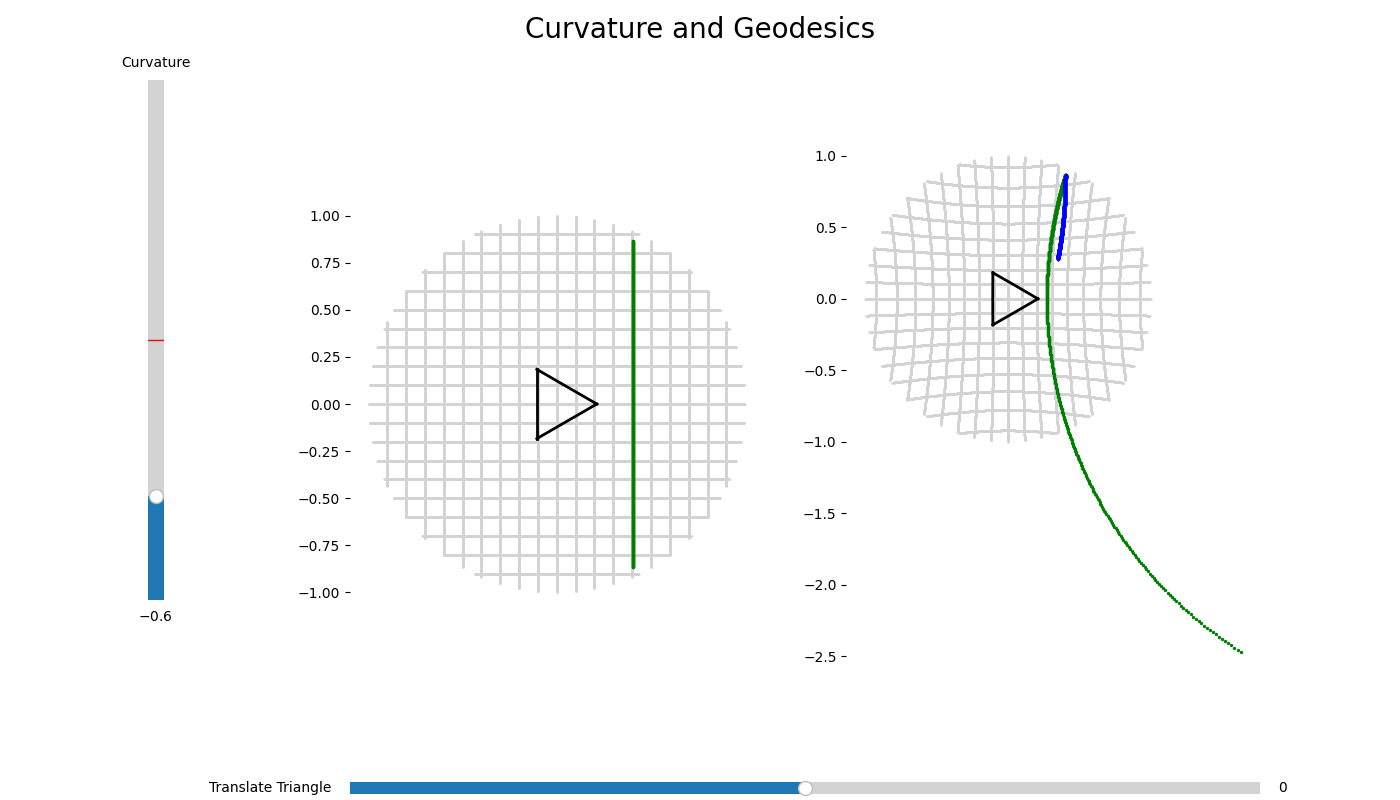

None

In [10]:
translate_triangle(t_slider.val)
display(plt.show(fig))

# <center> KITTIDATASET CLASS </center>

The following displays how the dataset is initialized and datapoints are visualized

In [ ]:
kitti = KittiDataset() # initialize data object
print(kitti)

In [ ]:
# visualisation/ transformations check
idx = random.choice(range(kitti.num_files))

# while not any([_['name'] =='Truck' for _ in kitti.get_label(idx)]):
#   idx = random.choice(range(kitti.num_files))
  
print(idx)
plt.imshow(kitti.get_image(idx))
kitti.inspect_points(frame_idx=idx,downsample_voxel_size=0.05)

In [ ]:
# creates and load json file conatining cropped boxes
# kitti.save_cropped_boxes()
cropped_labels,cropped_cam_points = kitti.load_cropped_boxes()

In [ ]:
# visualizes isolated objects
kitti.vis_cropped_boxes(cropped_labels,cropped_cam_points,object_class='Pedestrian')

In [ ]:
kitti.vis_crop_aug_sampler()

In [ ]:
calib = kitti.get_calib(0)

In [ ]:
calib['cam_to_image']